<a href="https://colab.research.google.com/github/farkoo/MNIST-Handwritten-Digit-Recognition-PyTorch/blob/master/MNIST_Handwritten_Digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

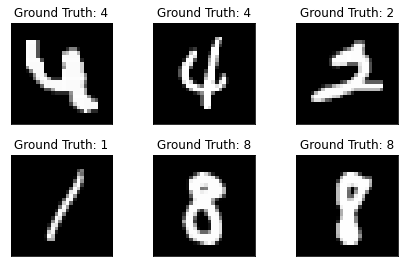

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i + 1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap = 'gray', interpolation = 'none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
# fig

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.conv2_drop  = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training = self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

In [8]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)

In [9]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [10]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [11]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [12]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3089, Accuracy: 674/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.368649
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.298366
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.294433
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.260970
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.295450
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.239506
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.274136
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.225711
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.168033
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.138118
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.061368
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.945130
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.949193
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.750880
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.642634
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.585531
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.416778
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.314595
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.256788
Train Epoch: 1 [12160/6

Text(0, 0.5, 'negative log likehood loss')

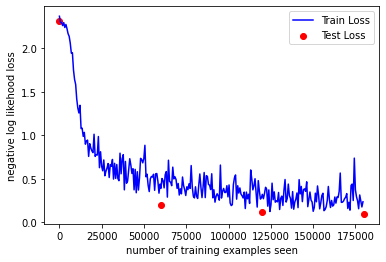

In [13]:
plt.plot(train_counter, train_losses, color = 'blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likehood loss')


In [14]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


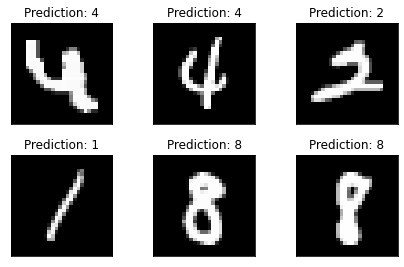

In [15]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [16]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [17]:
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [18]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.669169
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.193975
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.195679
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.307104
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.203755
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.238004
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.257517
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.335847
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.209687
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.280779
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.284504
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.287162
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.189130
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.319709
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.131248
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.271623
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.150488
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.381778
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.241011
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.357388
Train Epoch: 4 [12800/60000 (

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0840, Accuracy: 9731/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.145342
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.195255
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.433602
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.271662
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.121323
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.131053
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.223992
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.239263
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.335057
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.148383
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.209648
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.236725
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.277895
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.281379
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.271037
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.220026
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.342497
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.208678
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.245290
Train Epoch: 5 [12160

Text(0, 0.5, 'negative log likelihood loss')

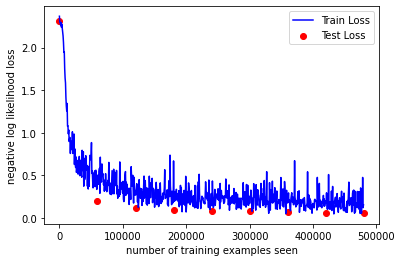

In [19]:
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')